<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/wganworkking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pandas

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [118]:
def make_generator_model():
    input_noise = layers.Input(shape=(100,))
    noise = layers.Dense(7*7*128)(input_noise)
    noise = layers.Reshape((7, 7, 128))(noise)

    input_digit = layers.Input(shape=(1,))
    digit = layers.Embedding(10, 49)(input_digit)
    digit = layers.Reshape((7, 7, 1))(digit)

    x = layers.concatenate([noise, digit])

    x = layers.Conv2DTranspose(128,3,2,padding='same',activation='LeakyReLU')(x)

    x = layers.Conv2DTranspose(128,3,2,padding='same',activation='LeakyReLU')(x)

    x = layers.Conv2D(1,3,1,padding='same',activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=(input_noise,input_digit), outputs=x)
    model.summary()
    return model


def make_discriminator_model():
    input_img = layers.Input(shape=(28,28,1))

    input_digit = layers.Input(shape=(1,))
    digit = layers.Embedding(10, 28*28)(input_digit)
    digit = layers.Reshape((28, 28, 1))(digit)

    x = layers.concatenate([input_img, digit])

    x = layers.Conv2D(256,5,2,padding='same',activation='LeakyReLU')(x)

    x = layers.Dropout(.6)(x)

    x = layers.Conv2D(256,3,2,padding='same',activation='LeakyReLU')(x)

    x = layers.Dropout(.6)(x)

    x = layers.Conv2D(256,3,2,padding='same',activation='LeakyReLU')(x)

    x = layers.Dropout(.6)(x)

    x = layers.Conv2D(256,3,2,padding='same',activation='LeakyReLU')(x)

    x = layers.Dropout(.6)(x)

    x = layers.Flatten()(x)

    dense_output = layers.Dense(128, activation='LeakyReLU')(x)


    x = layers.Dropout(.6)(x)

    dense_output = layers.Dense(64, activation='LeakyReLU')(x)

    x = layers.Dropout(.6)(x)

    dense_output = layers.Dense(1, activation=None)(dense_output)

    model = tf.keras.models.Model(inputs=(input_img,input_digit), outputs=dense_output)
    return model



In [120]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [119]:
generator = make_generator_model()
discriminatorW = make_discriminator_model()
discriminatorU = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(0.0004)
discriminatorW_optimizer = tf.keras.optimizers.Adam(0.0004)
discriminatorU_optimizer = tf.keras.optimizers.Adam(0.0004)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_49 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 input_50 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 dense_45 (Dense)            (None, 6272)                 633472    ['input_49[0][0]']            
                                                                                                  
 embedding_14 (Embedding)    (None, 1, 49)                490       ['input_50[0][0]']            
                                                                                           

In [121]:
BATCH_SIZE = 64

#@tf.function
def discriminator_lossW(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = fake_loss - real_loss
    return total_loss

#@tf.function
def generator_lossW(fake_output):
    return -tf.reduce_mean(fake_output)

#@tf.function
def gradient_penalty(real_images, fake_images,digits):
    alpha = tf.random.uniform([BATCH_SIZE, 1, 1, 1], 0., 1.)
    real_images, fake_images = tf.cast(real_images, tf.float32), tf.cast(fake_images, tf.float32)
    interpolated_images = alpha * real_images + ((1 - alpha) * fake_images)
    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        pred = discriminatorW((interpolated_images,digits), training=True)
    gradients = tape.gradient(pred, [interpolated_images])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

In [122]:
NOISE_DIM = 100
GP_WEIGHT = 10


#@tf.function
def train_step(images,digits):


    for i in range(3):
      with tf.GradientTape() as disc_tapeU:
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        generated_images = generator((noise,digits), training=True)

        real_outputU = discriminatorU((images,digits), training=True)
        fake_outputU = discriminatorU((generated_images,digits), training=True)
        disc_lossU = cross_entropy(tf.ones_like(real_outputU), real_outputU)




      gradients_of_discriminatorU = disc_tapeU.gradient(disc_lossU, discriminatorU.trainable_variables)
      discriminatorU_optimizer.apply_gradients(zip(gradients_of_discriminatorU, discriminatorU.trainable_variables))
      if i == 0:
        weights = discriminatorU.get_weights()


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tapeW:
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        generated_images = generator((noise,digits), training=True)

        real_outputW = discriminatorW((images,digits), training=True)
        fake_outputW = discriminatorW((generated_images,digits), training=True)
        real_outputU = discriminatorU((images,digits), training=True)
        fake_outputU = discriminatorU((generated_images,digits), training=True)
        disc_lossW = discriminator_lossW(real_outputW, fake_outputW)


        gen_lossU = cross_entropy(tf.ones_like(fake_outputU), fake_outputU)
        gen_lossW = generator_lossW(fake_outputW)
        gen_loss = gen_lossW+gen_lossU

        gp = gradient_penalty(images, generated_images, digits)
        disc_lossW += gp * GP_WEIGHT



    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    gradients_of_discriminatorW = disc_tapeW.gradient(disc_lossW, discriminatorW.trainable_variables)
    discriminatorW_optimizer.apply_gradients(zip(gradients_of_discriminatorW, discriminatorW.trainable_variables))

    discriminatorU.set_weights(weights)

    tf.print("disc_lossW",disc_lossW,'disc_lossU',disc_lossU,'gen_lossU',gen_lossU,'gen_lossW',gen_lossW)

In [89]:
def train(dataset,y_train, epochs):
  for epoch in range(epochs):
    for batch in range(len(dataset) // BATCH_SIZE):

            target_images = dataset[batch * BATCH_SIZE: (batch+1) * BATCH_SIZE]
            digits = y_train[batch * BATCH_SIZE: (batch+1) * BATCH_SIZE]

            train_step(target_images,digits)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      print(epoch)



In [ ]:
EPOCHS = 100
x_train2 = np.expand_dims(x_train, axis=-1)
x_train2 = (x_train2 - np.min(x_train2)) / (np.max(x_train2) - np.min(x_train2))
train(x_train2,y_train, EPOCHS)

disc_lossW -5.33928108 disc_lossU 3.38343085e-07 gen_lossU 2.53503663e-12 gen_lossW 5.28745174


1/1 [==============================] - 0s 28ms/step
tf.Tensor([9], shape=(1,), dtype=int32)


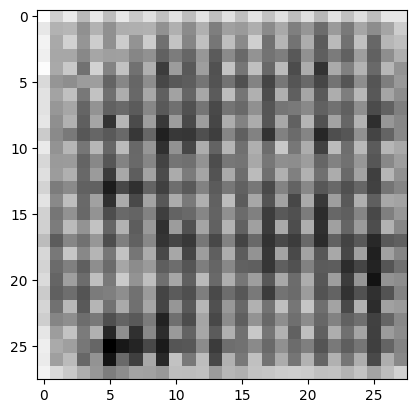

In [130]:
noise = tf.random.normal(shape=(1,100))
random_number = tf.random.uniform(shape=[1,], minval=0, maxval=10, dtype=tf.int32)
test = generator.predict((noise,random_number))
print(random_number)
plt.imshow(test.squeeze(), cmap='gray')
plt.show()

In [ ]:
print(np.min(x_train2))